In [78]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import InceptionV3, MobileNetV2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import random
from PIL import Image
from skimage import exposure  # For histogram equalization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage import feature, color, io
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import load_img, img_to_array
from sklearn.manifold import TSNE

## data exploration

In [47]:
# Set paths to your datasets
train_dir = r"C:\Users\CHIGUMBU T\Desktop\JULIACHISWINGA\juliaproj\train1"
val_dir = r"C:\Users\CHIGUMBU T\Desktop\JULIACHISWINGA\juliaproj\val1"
test_dir = r"C:\Users\CHIGUMBU T\Desktop\JULIACHISWINGA\juliaproj\test1"

# ImageDataGenerator for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Function to calculate F1 score
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return tf.py_function(f1_score, (y_true, y_pred), tf.double)

Found 4040 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [49]:
# Function to visualize the distribution of classes
def plot_class_distribution(train_dir):
    class_names = os.listdir(train_dir)
    class_counts = [len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=class_counts, palette='viridis')
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

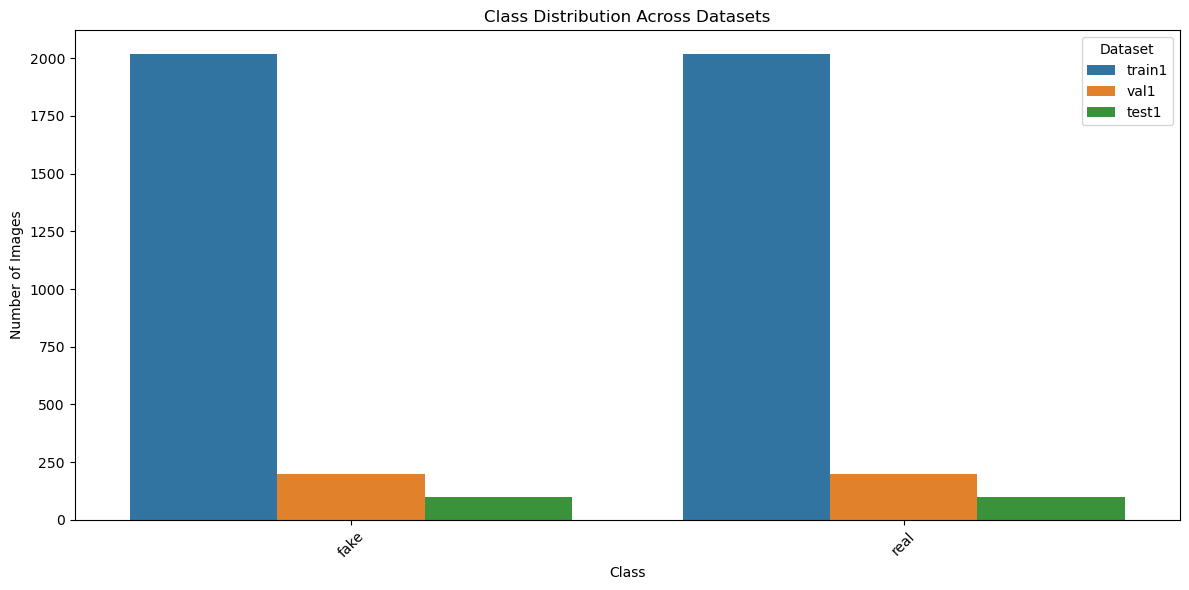

In [79]:
def class_distribution_plot(data_directories):
    all_counts = []

    # Loop through each data directory
    for data_directory in data_directories:
        class_names = os.listdir(data_directory)
        class_counts = [len(os.listdir(os.path.join(data_directory, class_name))) for class_name in class_names]
        
        # Prepare a DataFrame for each directory
        df = pd.DataFrame({'Class': class_names, 'Count': class_counts})
        df['Dataset'] = os.path.basename(data_directory)  # Add a column for the dataset name
        all_counts.append(df)

    # Concatenate all DataFrames
    combined_df = pd.concat(all_counts)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Class', y='Count', hue='Dataset', data=combined_df)
    plt.title('Class Distribution Across Datasets')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Images')
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

# Call the function with updated paths
class_distribution_plot([
    r"C:\Users\CHIGUMBU T\Desktop\JULIACHISWINGA\juliaproj\train1",
    r"C:\Users\CHIGUMBU T\Desktop\JULIACHISWINGA\juliaproj\val1",
    r"C:\Users\CHIGUMBU T\Desktop\JULIACHISWINGA\juliaproj\test1"
])

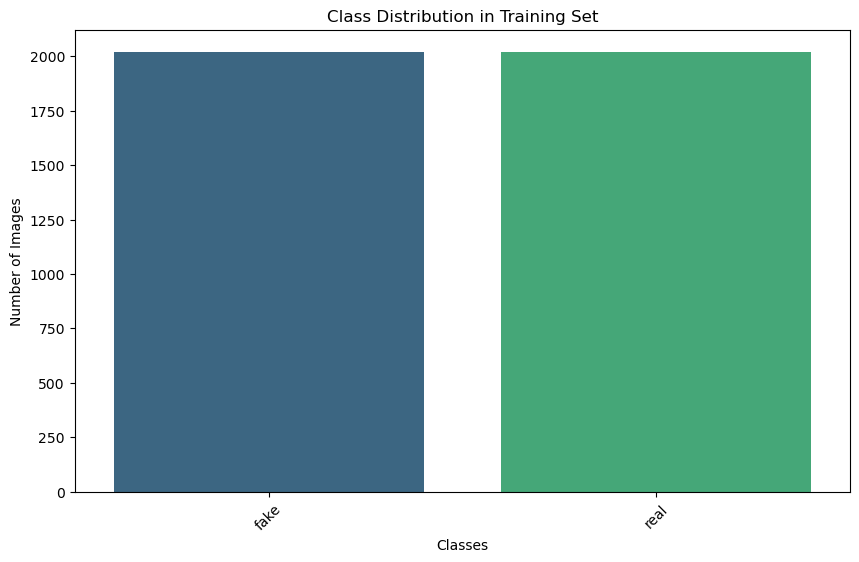

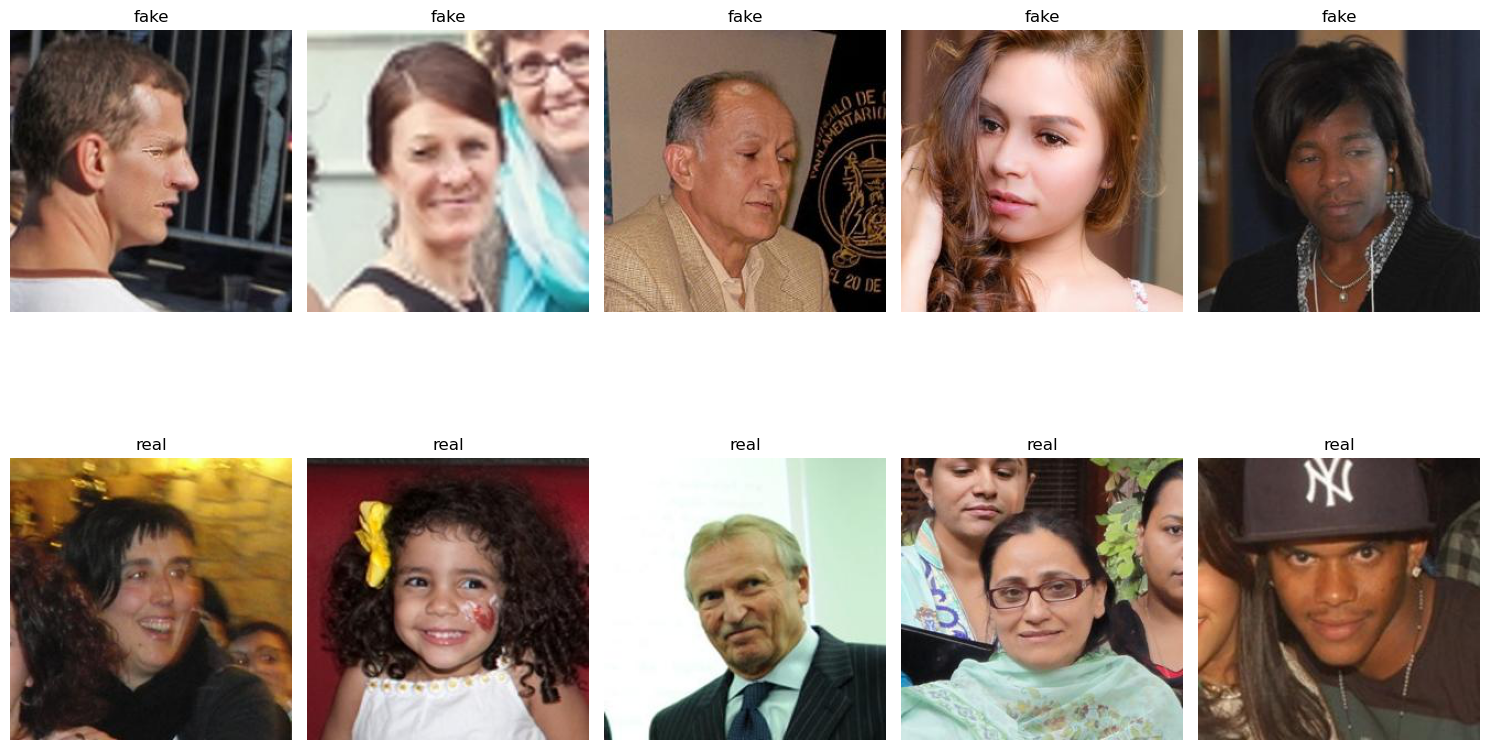

Total number of images: 4040
Total number of classes: 2
fake: 2020 images
real: 2020 images


In [51]:
# Function to get basic dataset statistics
def get_dataset_statistics(train_dir):
    total_images = sum([len(os.listdir(os.path.join(train_dir, class_name))) for class_name in os.listdir(train_dir)])
    print(f'Total number of images: {total_images}')
    print(f'Total number of classes: {len(os.listdir(train_dir))}')
    
    class_names = os.listdir(train_dir)
    for class_name in class_names:
        class_count = len(os.listdir(os.path.join(train_dir, class_name)))
        print(f'{class_name}: {class_count} images')

# Execute data exploration functions
plot_class_distribution(train_dir)
display_sample_images(train_dir, num_samples=5)
get_dataset_statistics(train_dir)

## Data Preprocessing

In [52]:
# Set parameters for image preprocessing
image_size = (150, 150)  # Resize images to this size
batch_size = 32           # Set batch size

# Create ImageDataGenerators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0, 1]
    rotation_range=40,                  # Randomly rotate images in the range (degrees)
    width_shift_range=0.2,              # Randomly shift images horizontally
    height_shift_range=0.2,             # Randomly shift images vertically
    shear_range=0.2,                    # Shear transformation
    zoom_range=0.2,                     # Randomly zoom in
    horizontal_flip=True,               # Randomly flip images
    fill_mode='nearest'                 # Fill in new pixels after transformations
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only normalize for validation set

test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalize for test set

# Load datasets with the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  # Change to 'categorical' if you have more than two classes
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 4040 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


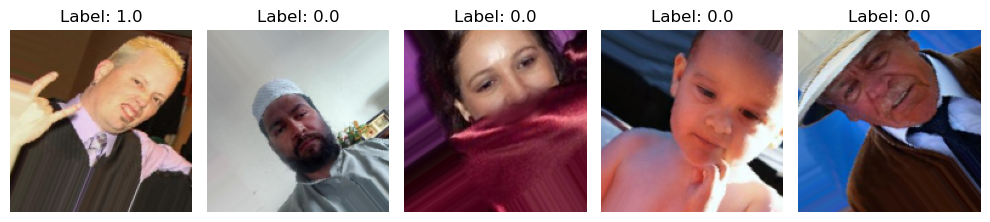

In [53]:
# Function to display sample preprocessed images
def display_preprocessed_images(generator, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        img, label = generator.next()  # Get the next batch of images and labels
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img[0])  # Display the first image in the batch
        plt.title(f'Label: {label[0]}')  # Display the corresponding label
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Preview a sample of preprocessed images from the training set
display_preprocessed_images(train_generator, num_samples=5)

In [55]:
# Function for histogram equalization
def equalize_image(image):
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # Apply histogram equalization to the L channel
    l_eq = exposure.equalize_hist(l)
    # Merge back the channels
    lab_eq = cv2.merge((l_eq, a, b))
    return cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)

# Example of using histogram equalization within ImageDataGenerator
class CustomImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, *args, **kwargs):
        generator = super().flow_from_directory(*args, **kwargs)
        while True:
            batch_x, batch_y = next(generator)
            # Apply histogram equalization to each image in the batch
            for i in range(len(batch_x)):
                batch_x[i] = equalize_image(batch_x[i])
            yield batch_x, batch_y

# Use the custom generator instead
train_datagen = CustomImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

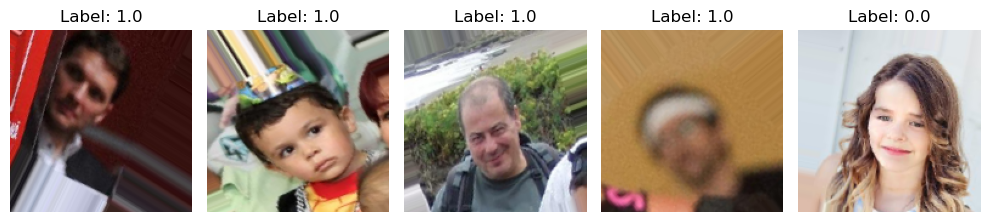

In [56]:
# Function to display sample preprocessed images
def display_preprocessed_images(generator, num_samples=5):
    plt.figure(figsize=(10, 10))
    
    # Retrieve a batch of images and labels
    img, label = next(generator)
    
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img[i])  # Display the i-th image in the batch
        plt.title(f'Label: {label[i]}')  # Display the corresponding label
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Preview a sample of preprocessed images from the training set
display_preprocessed_images(train_generator, num_samples=5)

In [66]:
# Function to extract HOG features from an image
def extract_hog_features(image):
    gray_image = color.rgb2gray(image)  # Convert to grayscale
    hog_features = feature.hog(gray_image,
                                orientations=8,
                                pixels_per_cell=(16, 16),
                                cells_per_block=(1, 1),
                                visualize=False)
    return hog_features

# Load images from a directory
def load_images_from_folder(folder):
    features = []
    labels = []
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']  # Add more formats if needed

    for filename in os.listdir(folder):
        if any(filename.lower().endswith(ext) for ext in valid_extensions):
            img = io.imread(os.path.join(folder, filename))
            if img is not None:
                features.append(extract_hog_features(img))
                labels.append(filename.split('_')[0])  # Assuming filename format "label_image.jpg"
        else:
            print(f"Skipped file: {filename}")  # Debugging output for non-image files
    
    return np.array(features), np.array(labels)

# Example usage: Load images from a folder and extract features
folder_path = r'C:\Users\CHIGUMBU T\Desktop\JULIACHISWINGA\juliaproj\train1'  # Change to your image directory
train_features, train_labels = load_images_from_folder(folder_path)

# If necessary, flatten the features
train_features = np.array(train_features)

# Continue with your analysis (e.g., PCA and plotting)

Skipped file: fake
Skipped file: real
Skipped file: fake
Skipped file: real


## feature extraction

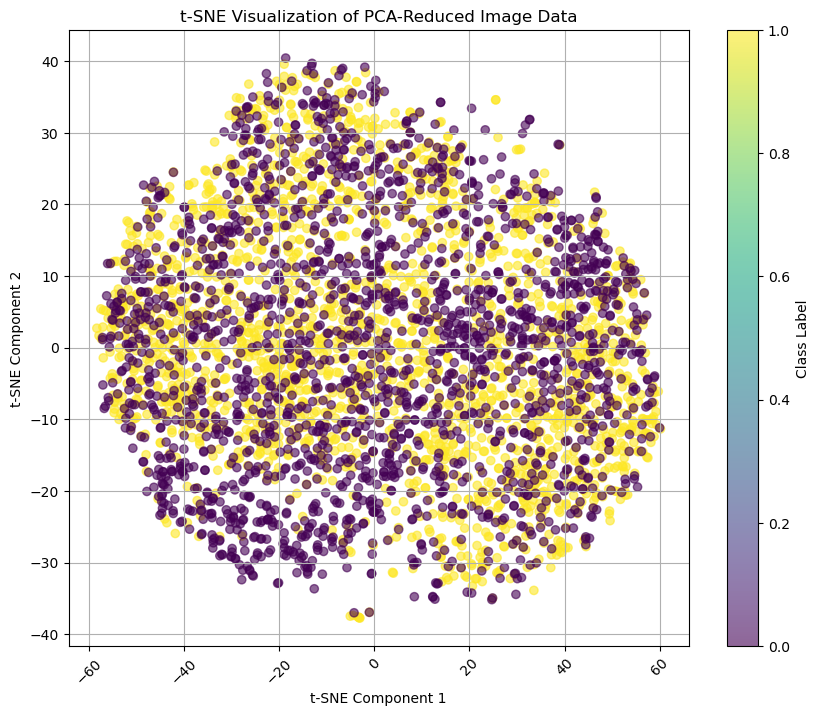

In [74]:
# Set the dataset directory
dataset_dir = r'C:\Users\CHIGUMBU T\Desktop\JULIACHISWINGA\juliaproj\train1'

# Load images and labels
images = []
labels = []

# Define the classes we're interested in
classes = ['real', 'fake']

for label in classes:
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            # Load and resize image
            img = load_img(img_path, target_size=(64, 64))  # Adjust size as needed
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Flatten the image data
n_samples, height, width, channels = X.shape
X_flat = X.reshape(n_samples, -1)  # Flatten the images

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# PCA for Dimensionality Reduction
pca = PCA(n_components=50)  # Adjust number of components as needed
X_pca = pca.fit_transform(X_flat)

# t-SNE for Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Plotting t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='viridis', alpha=0.6)
plt.title('t-SNE Visualization of PCA-Reduced Image Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Class Label')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

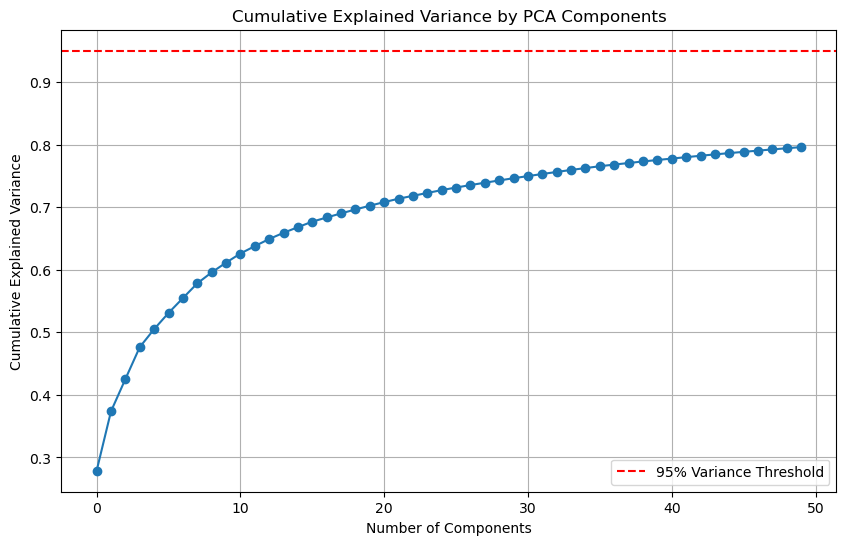

In [75]:
# Set the dataset directory
dataset_dir = r'C:\Users\CHIGUMBU T\Desktop\JULIACHISWINGA\juliaproj\train1'

# Load images and labels
images = []
labels = []

# Define the classes we're interested in
classes = ['real', 'fake']

for label in classes:
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            # Load and resize image
            img = load_img(img_path, target_size=(64, 64))  # Adjust size as needed
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Flatten the image data
n_samples, height, width, channels = X.shape
X_flat = X.reshape(n_samples, -1)  # Flatten the images

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# PCA for Dimensionality Reduction
pca = PCA(n_components=50)  # Adjust number of components as needed
X_pca = pca.fit_transform(X_flat)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')  # Line at 95% cumulative variance
plt.legend()
plt.show()

In [71]:
# Set the dataset directory
dataset_dir = r'C:\Users\CHIGUMBU T\Desktop\JULIACHISWINGA\juliaproj\train1'

# Load images and labels
images = []
labels = []

# Define the classes we're interested in
classes = ['real', 'fake']

for label in classes:
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            # Load and resize image
            img = load_img(img_path, target_size=(64, 64))  # Adjust size as needed
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Flatten the image data
n_samples, height, width, channels = X.shape
X_flat = X.reshape(n_samples, -1)  # Flatten the images

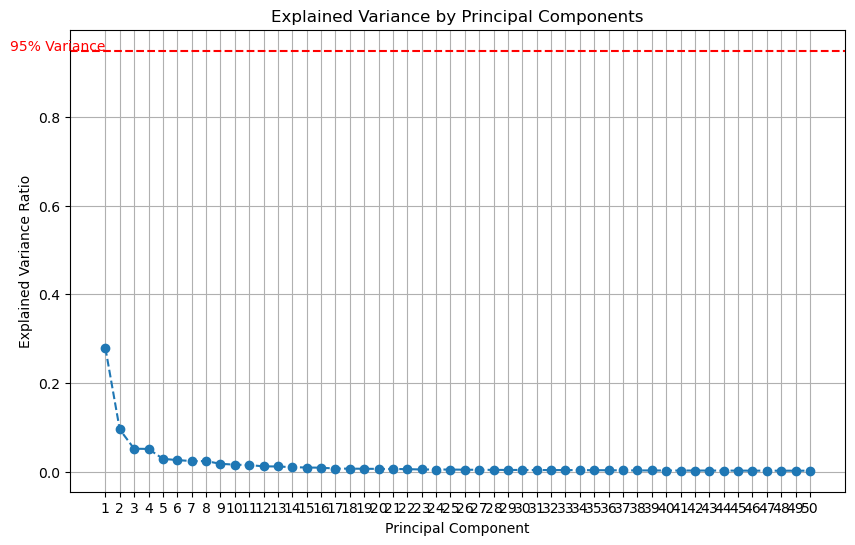

In [72]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# PCA for Dimensionality Reduction
pca = PCA(n_components=50)  # Adjust number of components as needed
X_pca = pca.fit_transform(X_flat)

# Explained Variance
explained_variance = pca.explained_variance_ratio_

# Plotting Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--')  # Line at 95% cumulative variance
plt.text(1, 0.95, '95% Variance', color='red', ha='right')
plt.show()

## model training

In [48]:
# Build and compile models
def create_model(model_type):
    if model_type == "custom_cnn":
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
    elif model_type == "inception":
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        base_model.trainable = False
    elif model_type == "mobilenet":
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        base_model.trainable = False

    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), f1_metric])
    return model

In [39]:
# Train the models
def train_model(model, train_gen, val_gen, model_name):
    print(f"Training {model_name} for 20 epochs...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20
    )
    return history

In [40]:
# Function to get predictions
def get_predictions(model, generator):
    predictions = []
    for x, _ in generator:
        preds = model.predict(x)
        predictions.append(preds)
    return np.concatenate(predictions)

In [41]:
# Create and train the models
custom_cnn_model = create_model("custom_cnn")
cnn_history = train_model(custom_cnn_model, train_generator, val_generator, "Custom CNN")

inception_model = create_model("inception")
inception_history = train_model(inception_model, train_generator, val_generator, "Inception V3")

mobilenet_model = create_model("mobilenet")
mobilenet_history = train_model(mobilenet_model, train_generator, val_generator, "MobileNetV2")

# Function to summarize model performance
def summarize_model_performance(y_true, y_pred, model_name):
    y_pred_classes = np.round(y_pred)  # Convert probabilities to class labels
    accuracy = np.mean(y_pred_classes == y_true)
    precision = precision_score(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes)
    
    print(f"{model_name} Performance Summary:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}\n")


Training Custom CNN for 20 epochs...
Epoch 1/20
127/127 [==============================] - 124s 966ms/step - loss: 0.6824 - accuracy: 0.5787 - precision_11: 0.5662 - recall_11: 0.6733 - f1_metric: 0.5781 - val_loss: 0.5571 - val_accuracy: 0.7450 - val_precision_11: 0.7988 - val_recall_11: 0.6550 - val_f1_metric: 0.7198
Epoch 2/20
127/127 [==============================] - 123s 965ms/step - loss: 0.5592 - accuracy: 0.7129 - precision_11: 0.6976 - recall_11: 0.7515 - f1_metric: 0.7146 - val_loss: 0.4885 - val_accuracy: 0.7625 - val_precision_11: 0.8344 - val_recall_11: 0.6550 - val_f1_metric: 0.7335
Epoch 3/20
127/127 [==============================] - 124s 979ms/step - loss: 0.4802 - accuracy: 0.7639 - precision_11: 0.7447 - recall_11: 0.8030 - f1_metric: 0.7693 - val_loss: 0.5392 - val_accuracy: 0.7525 - val_precision_11: 0.8582 - val_recall_11: 0.6050 - val_f1_metric: 0.6969
Epoch 4/20
127/127 [==============================] - 130s 1s/step - loss: 0.4363 - accuracy: 0.8005 - precisio

Epoch 10/20
127/127 [==============================] - 132s 1s/step - loss: 0.4284 - accuracy: 0.7943 - precision_12: 0.7819 - recall_12: 0.8163 - f1_metric: 0.7902 - val_loss: 0.5323 - val_accuracy: 0.7500 - val_precision_12: 0.9237 - val_recall_12: 0.5450 - val_f1_metric: 0.6832
Epoch 11/20
127/127 [==============================] - 131s 1s/step - loss: 0.4225 - accuracy: 0.7965 - precision_12: 0.7858 - recall_12: 0.8153 - f1_metric: 0.7926 - val_loss: 0.5039 - val_accuracy: 0.7700 - val_precision_12: 0.9219 - val_recall_12: 0.5900 - val_f1_metric: 0.7101
Epoch 12/20
127/127 [==============================] - 132s 1s/step - loss: 0.4111 - accuracy: 0.8017 - precision_12: 0.7826 - recall_12: 0.8356 - f1_metric: 0.8045 - val_loss: 0.4834 - val_accuracy: 0.7700 - val_precision_12: 0.9091 - val_recall_12: 0.6000 - val_f1_metric: 0.7192
Epoch 13/20
127/127 [==============================] - 131s 1s/step - loss: 0.3979 - accuracy: 0.8104 - precision_12: 0.8012 - recall_12: 0.8257 - f1_metr

127/127 [==============================] - 68s 536ms/step - loss: 0.2018 - accuracy: 0.9136 - precision_13: 0.9094 - recall_13: 0.9188 - f1_metric: 0.9107 - val_loss: 0.6338 - val_accuracy: 0.7350 - val_precision_13: 0.8917 - val_recall_13: 0.5350 - val_f1_metric: 0.6605
Epoch 19/20
127/127 [==============================] - 68s 532ms/step - loss: 0.1872 - accuracy: 0.9186 - precision_13: 0.9122 - recall_13: 0.9262 - f1_metric: 0.9167 - val_loss: 0.6054 - val_accuracy: 0.7525 - val_precision_13: 0.9106 - val_recall_13: 0.5600 - val_f1_metric: 0.6798
Epoch 20/20
127/127 [==============================] - 68s 532ms/step - loss: 0.1843 - accuracy: 0.9252 - precision_13: 0.9198 - recall_13: 0.9317 - f1_metric: 0.9229 - val_loss: 0.5324 - val_accuracy: 0.7675 - val_precision_13: 0.8905 - val_recall_13: 0.6100 - val_f1_metric: 0.6996


In [42]:
# Get true labels
y_true = test_generator.classes

# Predictions
y_pred_cnn = custom_cnn_model.predict(test_generator).flatten()
y_pred_inception = inception_model.predict(test_generator).flatten()
y_pred_mobilenet = mobilenet_model.predict(test_generator).flatten()

# Summarize model performance
summarize_model_performance(y_true, y_pred_cnn, 'Custom CNN')
summarize_model_performance(y_true, y_pred_inception, 'Inception V3')
summarize_model_performance(y_true, y_pred_mobilenet, 'MobileNetV2')


7/7 [==============================] - 4s 406ms/step
Custom CNN Performance Summary:
Accuracy: 0.77
Precision: 0.75
Recall: 0.82
F1 Score: 0.78

Inception V3 Performance Summary:
Accuracy: 0.71
Precision: 0.70
Recall: 0.74
F1 Score: 0.72

MobileNetV2 Performance Summary:
Accuracy: 0.70
Precision: 0.69
Recall: 0.74
F1 Score: 0.71



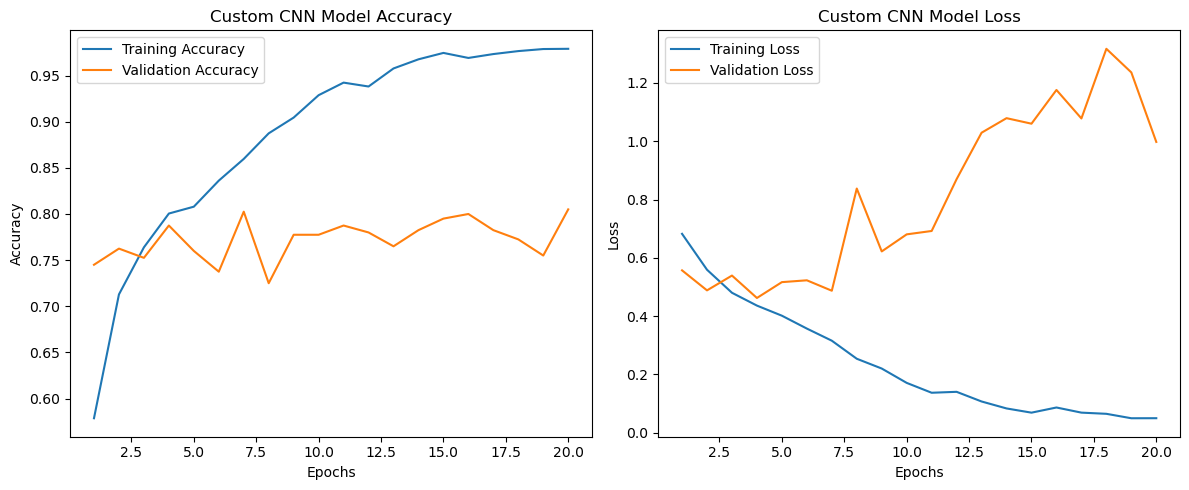

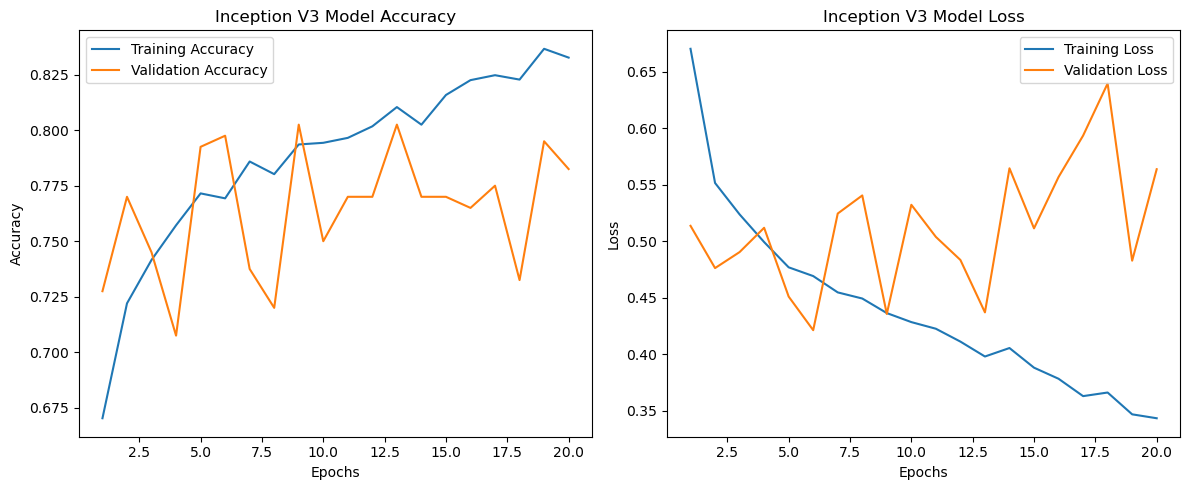

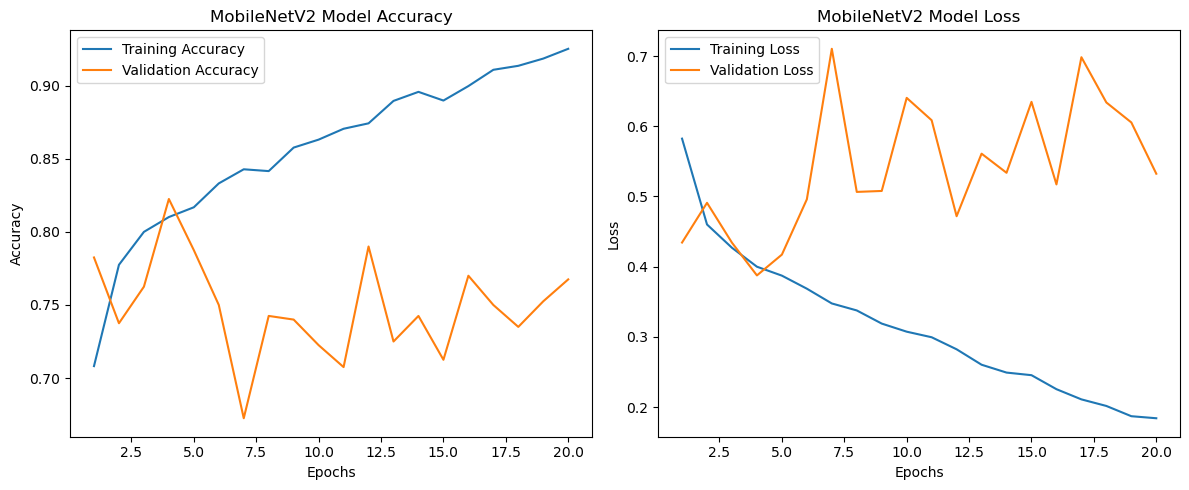

In [43]:
# Plot accuracy and loss
def plot_accuracy_loss(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting accuracy and loss for each model
plot_accuracy_loss(cnn_history, "Custom CNN")
plot_accuracy_loss(inception_history, "Inception V3")
plot_accuracy_loss(mobilenet_history, "MobileNetV2")

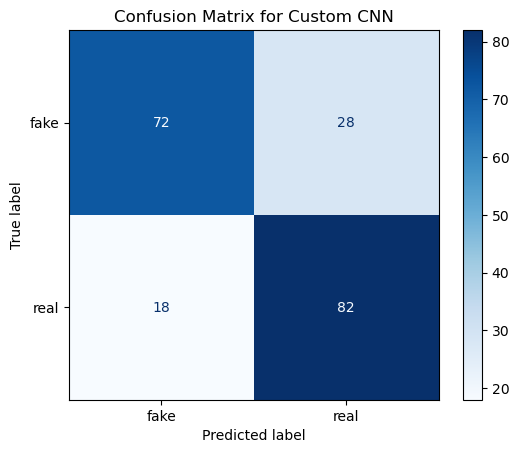

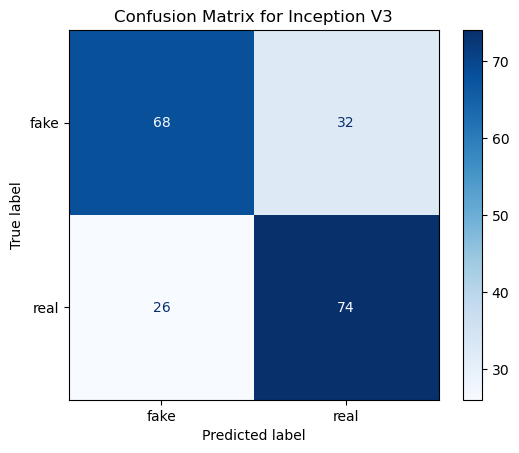

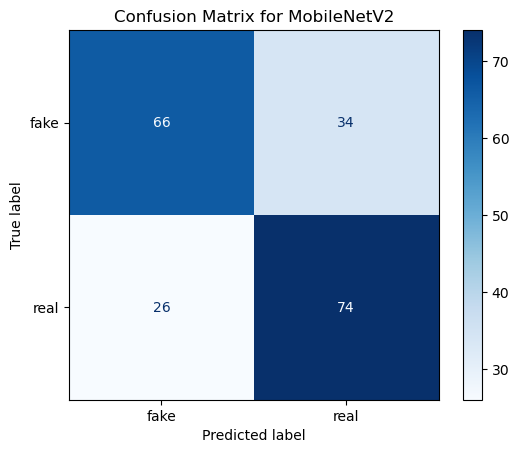

In [44]:
# Function to compute confusion matrix and plot
def plot_confusion_matrix(y_true, y_pred, model_name):
    y_pred_classes = np.round(y_pred)  # Convert probabilities to class labels
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(y_true, y_pred_cnn, 'Custom CNN')
plot_confusion_matrix(y_true, y_pred_inception, 'Inception V3')
plot_confusion_matrix(y_true, y_pred_mobilenet, 'MobileNetV2')


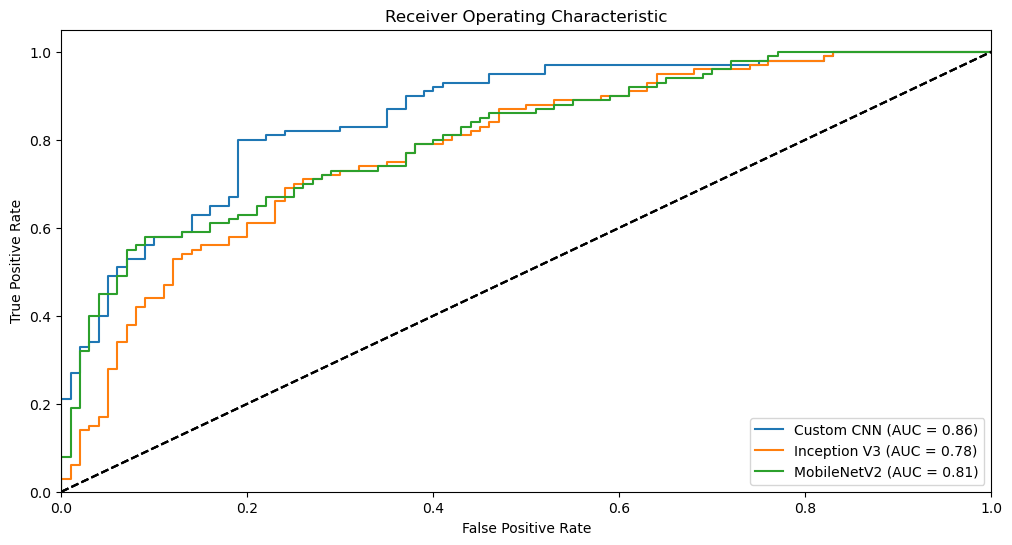

In [45]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

# Plot ROC curves for each model
plt.figure(figsize=(12, 6))
plot_roc_curve(y_true, y_pred_cnn, 'Custom CNN')
plot_roc_curve(y_true, y_pred_inception, 'Inception V3')
plot_roc_curve(y_true, y_pred_mobilenet, 'MobileNetV2')
plt.show()